<a href="https://colab.research.google.com/github/kristinanett/02456-deep-learning-with-PyTorch/blob/master/8_Reinforcement/8.3-EXE_Policy_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [197]:
# Install colabgymrender to display gym environments in Colab
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [198]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers
from colabgymrender.recorder import Recorder

First we create the environment:

In [199]:
env = gym.make('CartPole-v0') # Create environment

A state in this environment is four numbers describing the position of the cart along with the angle and speed of the pole.
There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [200]:
s = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [-0.02525467  0.00505608 -0.04791625 -0.00976101]
sample action: 1


Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [201]:
env = gym.make('CartPole-v0') # Create environment
env = Recorder(env, "./video") # To display environment in Colab
env.reset() # Reset environment

# Run environment
while True:
    env.render() # Render environment
    action = env.action_space.sample() # Get a random action
    _, _, done, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
env.play()

100%|██████████| 13/13 [00:00<00:00, 232.29it/s]


Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [209]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        #self.hidden2 = nn.Linear(n_hidden, 50)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        #x = self.hidden2(x)
        #x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [210]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [211]:
n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [212]:
# training settings

num_episodes = 900
rollout_limit = 500 # max rollout length
discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.005 #0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
 100. mean training reward:  28.96, mean validation reward:  41.60, mean loss:  9.9446
 200. mean training reward:  50.50, mean validation reward:  68.00, mean loss: 15.7347
 300. mean training reward:  92.46, mean validation reward: 174.60, mean loss: 25.3572
 400. mean training reward: 140.91, mean validation reward: 200.00, mean loss: 35.8591
 500. mean training reward: 177.33, mean validation reward: 200.00, mean loss: 45.2643
 600. mean training reward: 165.71, mean validation reward: 200.00, mean loss: 38.9419
 700. mean training reward: 180.73, mean validation reward: 200.00, mean loss: 44.3967
 800. mean training reward: 195.03, mean validation reward: 200.00, mean loss: 44.9660
 900. mean training reward: 181.36, mean validation reward: 200.00, mean loss: 40.3773
done


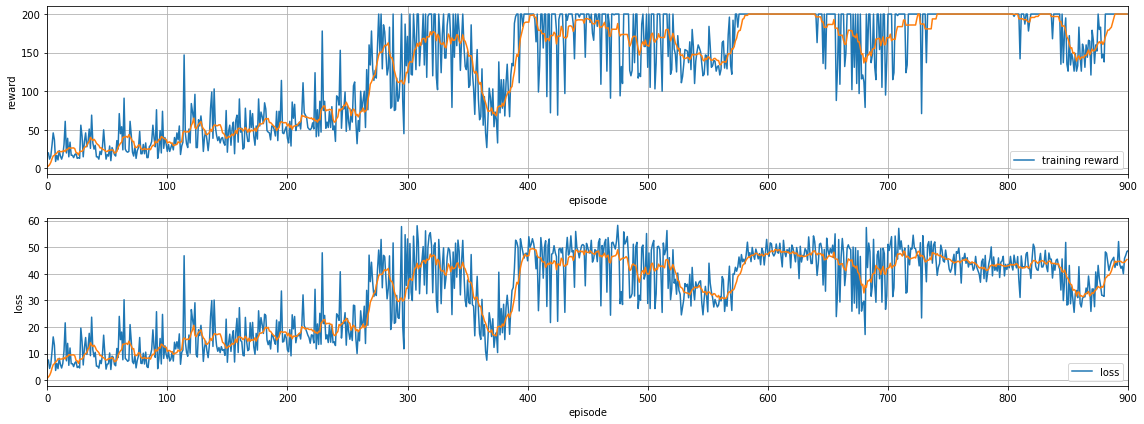

In [213]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [214]:
env = Recorder(env, "./gym-results") # wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    env.render()
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break
    
# env.close()
env.play()

100%|█████████▉| 201/202 [00:00<00:00, 287.89it/s]


## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

First I experimented with increasing the number of episodes from 800 to 1500 which improved the overall result. The video lasted for 6 seconds and terminated because the pole was successfully balanced for some fixed duration. The training reward was 180 and validation reward 200 (saturated at 1000 episodes). Since this took a longer time to train and seemed to be overdoing it I settled on 1000 episodes.  

Next I started trying different discount factors. The values I tried were: 0.7, 0.9, 0.97 (and the initial 1.0) and I concluded that in this case the higher the value the better the results. With 0.7 and 0.9 the video lasted 0 seconds and the pole fell over instantly, the mean training and validation reward were around 10 and 20 respectively. When increasing the value to 0.97 the result was pretty much the same as with 1.0 resulting in a 6 second video terminated by having successfully balanced for some time. The mean training reward was around 70 and validation around 195. For future experiments I set the value to 1.0 which seemed to be optimal.

Then I experimented with increasing the learning rate. I used 0.001 (original), 0.005 and 0.01. Learning rate of 0.005 gave the best results. When increasing the rate further to 0.01 the system became unstable. Due to this change in learning rate I was also able to decrease the number of episodes.

Lastly I added one more hidden layer with 50 units which seemed to give a better performance at first, therefore I added another layer with 100 units which seemed to make the whole thing more unstable so I went back to only having 2 layers in the network. After having run the code with two layers a few times I concluded that adding a layer actually made the system more unpredictable (made the training and validation rewards more fluctuating) so I went back to the initial network design.

During the experimentation the system did not give good results consistently.

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

I used the following equations to calculate the total reward, total future reward for each timestep and the discounted future reward in each timestep:

\begin{equation}
R = \sum_{t=0}^{T} r_{t}
\end{equation}

\begin{equation}
R_{t}=r_{t}+r_{t+1}+r_{t+2}+\cdots+r_{T}=\sum_{k=0}^{T-t} r_{t+k}
\end{equation}

\begin{equation}
R_{t}=r_{t}+\gamma r_{t+1}+\gamma^{2} r_{t+2}+\cdots+\gamma^{T-t} r_{T}=\sum_{k=0}^{T-t} \gamma^{k} r_{t+k}
\end{equation}

I obtained the following results (the code for calculating them can be seen at the end of this notebook):

* Total reward equals: 5

* Total future reward for each timestep is:  [5, 5, 4, 3, 2, 2, 1, 0, 0, 0]

* The discounted future reward for each timestep is:  [3.560931, 3.95659, 3.2851, 2.539, 1.71, 1.9, 1.0, 0.0, 0.0, 0.0]

### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

In the training part, each action is chosen stochasticly based on the different probability at every step: a = torch.multinomial(a_prob, num_samples=1). However, in the validation part, the action which has higher probability is always chosen at every step: a = a_prob.argmax()

In the beginning the system is exploring and random actions are better than our network so the validation reward is very low, but as the network is updated, the network is able to take better actions than just random.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

We use a softmax function in our neural network output therefore we can say that our policy provides a probability distribution over actions and then we can select an action by sampling from this distribution (a = torch.multinomial(a_prob, num_samples=1)). An inherent property of the sampling approach is that it will gradually reduce exploration and start exploiting as it learns and becomes more confident in the most rewarding actions.

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate. 

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*

##Exercise 2 code## 

In [215]:
series = [0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

#calculating the total reward 
print("Total reward equals: " + str(sum(series)))

#calculating the total future reward for each timestep
total_future_reward = []
for i in range(len(series)):
  one_step_sum = 0
  for j in range(len(series)-i):
    one_step_sum += series[i+j]
  total_future_reward.append(one_step_sum)

print("Total future reward for each timestep is: ", total_future_reward)

#calculating the discounted future reward for each timestep
discount_rate = 0.9
discounted_future_reward = []
for i in range(len(series)):
  one_step_sum = 0
  for j in range(len(series)-i):
    one_step_sum += (discount_rate**j)*series[i+j]
  discounted_future_reward.append(one_step_sum)

print("The discounted future reward for each timestep is: ", discounted_future_reward)

Total reward equals: 5
Total future reward for each timestep is:  [5, 5, 4, 3, 2, 2, 1, 0, 0, 0]
The discounted future reward for each timestep is:  [3.560931, 3.95659, 3.2851, 2.539, 1.71, 1.9, 1.0, 0.0, 0.0, 0.0]


## Exercise from Michael Nielsen's book ## 

Exercise from chapter 3: 

**As discussed above, one way of expanding the MNIST training data is to use small rotations of training images. What's a problem that might occur if we allow arbitrarily large rotations of training images?**

Having the numbers rotated by a small angle is not a problem and can be used to help the model generalize better. The problem with bigger rotations is that numbers are not invariant to rotations. When you rotate a 6 by 180 degrees it becomes a 9. When we allow rotations of both 6s and 9s in our training data it will become very difficult to distinguish the two.